In [ ]:
BASE_PATH = "/content/drive/MyDrive/Académico/UNIR/MUQC/99 - TFM/dev"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import time
import pandas as pd
# usaremos "from pennylane import numpy as np" tras la instalación de PennyLane para el uso de los métodos de diferenciación automática
#import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 65.0 MB/s eta 0:00:00


In [ ]:
!pip install cuquantum

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 MB 1.6 MB/s eta 0:00:00
  Created wheel for cuquantum: filename=cuquantum-24.3.0.post1-0_cu12-py3-none-any.whl size=10532 sha256=bb3310cb3fe8347530d2ed4f032b08684aa1504507223e08761dd23bf6159ba2
  Stored in directory: /root/.cache/pip/wheels/1d/4e/b7/1ae412184f72b750bf9429ca492cf9d4aeb405e7846a9e0907
Successfully built cuquantum


In [ ]:
!pip install pennylane-lightning[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 1.4 MB/s eta 0:00:00


In [ ]:
from pennylane import numpy as np

In [ ]:
N_QUBITS = 3

In [ ]:
RANDOM_SEED = 1234

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

In [ ]:
PCA_COMPONENTS = 8

In [ ]:
df_tr_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/tr_day_syn_small.csv")

In [ ]:
df_test_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/test_day_syn_small.csv")

In [ ]:
x_tr = df_tr_day_syn_resampled.drop(columns = " Label").to_numpy()

In [ ]:
y_tr = df_tr_day_syn_resampled[" Label"].to_numpy()

In [ ]:
x_test = df_test_day_syn_resampled.drop(columns = " Label").to_numpy()

In [ ]:
y_test = df_test_day_syn_resampled[" Label"].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size = 0.5, stratify = y_test)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)

x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = PCA_COMPONENTS)

In [ ]:
start = time.time()

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 0.05833315849304199 s


In [ ]:
import pennylane as qml

In [ ]:
dev = qml.device("lightning.gpu", wires = N_QUBITS)

In [ ]:
@qml.qnode(dev)
def kernel_circ(a, b):
  qml.AmplitudeEmbedding(
      a, wires = range(N_QUBITS), pad_with = 0, normalize = True)
  qml.adjoint(qml.AmplitudeEmbedding(
      b, wires = range(N_QUBITS), pad_with = 0, normalize = True))
  return qml.probs(wires = range(N_QUBITS))

(<Figure size 500x400 with 1 Axes>, <Axes: >)


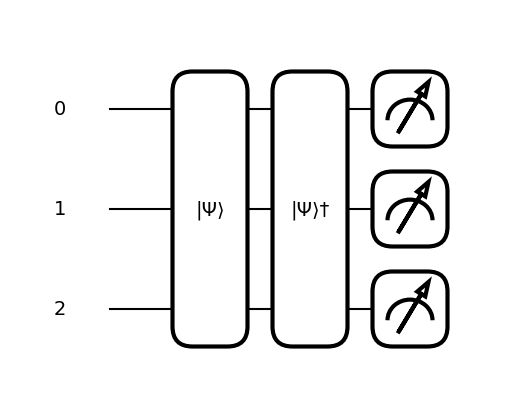

In [ ]:
print(qml.draw_mpl(kernel_circ)(xs_tr[0], xs_tr[0]))

In [ ]:
def qkernel(A, B):
  return np.array([[kernel_circ(a, b)[0] for b in B] for a in A])

In [ ]:
from sklearn import svm

model = svm.SVC(kernel = qkernel)

In [ ]:
start = time.time()

In [ ]:
model.fit(xs_tr, y_tr)

SVC(kernel=<function qkernel at 0x7e75356ea7a0>)

In [ ]:
end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 4432.0240161418915 s


In [ ]:
from sklearn.metrics import accuracy_score

start = time.time()

tr_acc = accuracy_score(model.predict(xs_tr) >= 0.5, y_tr)
val_acc = accuracy_score(model.predict(xs_val) >= 0.5, y_val)
test_acc = accuracy_score(model.predict(xs_test) >= 0.5, y_test)

end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 5502.472592830658 s


In [ ]:
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.99625
Validation accuracy: 0.99
Test accuracy: 0.97


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
output = model.predict(xs_test)
result = (output > 0.5).astype(float)

In [ ]:
confusion_matrix(y_true = y_test, y_pred = result)

array([[89,  1],
       [ 2,  8]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_test, y_pred = result))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        90
           1       0.89      0.80      0.84        10

    accuracy                           0.97       100
   macro avg       0.93      0.89      0.91       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
from sklearn.metrics import roc_curve

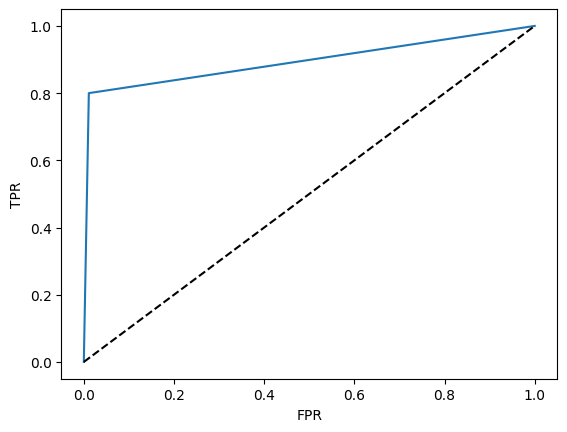

In [ ]:
fpr, tpr, _ = roc_curve(y_test, output)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "black")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

In [ ]:
from sklearn.metrics import auc

print(auc(fpr, tpr))

0.8944444444444445
